In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# get airline passenger data 

!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-04-09 12:07:33--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-04-09 12:07:34 (8.30 MB/s) - 'airline_passengers.csv' saved [2036/2036]



In [4]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


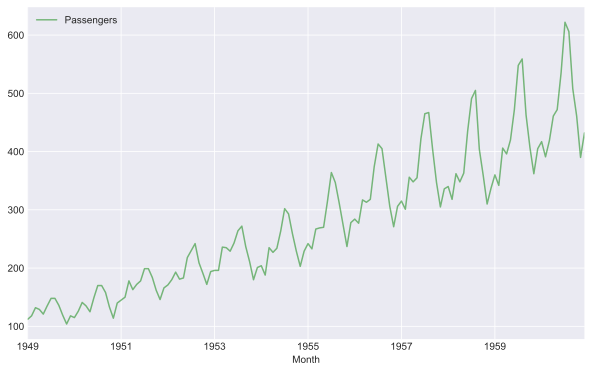

In [8]:
fig, axes = plt.subplots(figsize = (10,6))

df.plot(ax = axes, color = 'green', alpha = 0.5)

axes.grid()

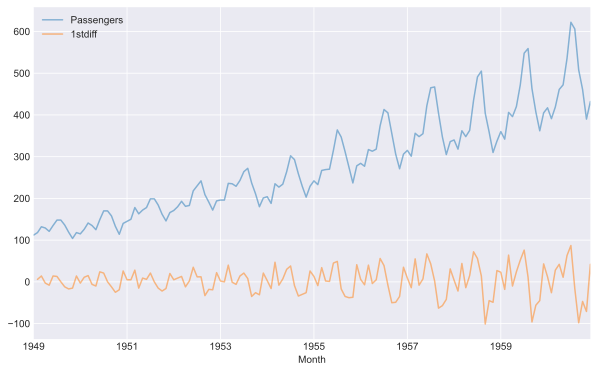

In [10]:
# get the first difference and add it to the df and plot 

df['1stdiff'] = df['Passengers'].diff()

fig, axes = plt.subplots(figsize = (10,6))

df.plot(ax = axes, alpha = 0.5)

axes.grid()

Notice that 1st differencing does not lead to stationarity. 

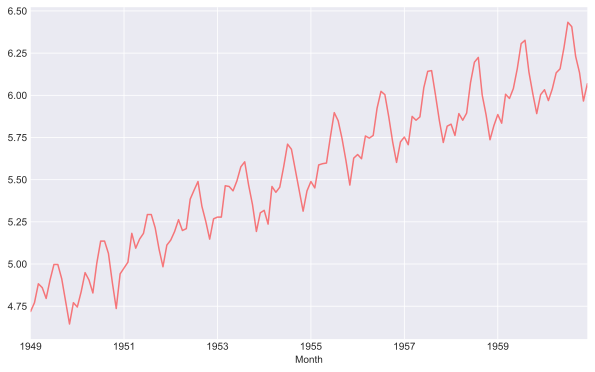

In [12]:
# perform log transform to the Passenger count and plot 

df['LogPassengers'] = np.log(df['Passengers'])

fig, axes = plt.subplots(figsize = (10,6))

df['LogPassengers'].plot(ax = axes, color = 'red', alpha = 0.5)

axes.grid()

Notice that amplitude of the cycles appear to be more constant after we take the log transform of the passenger count.  


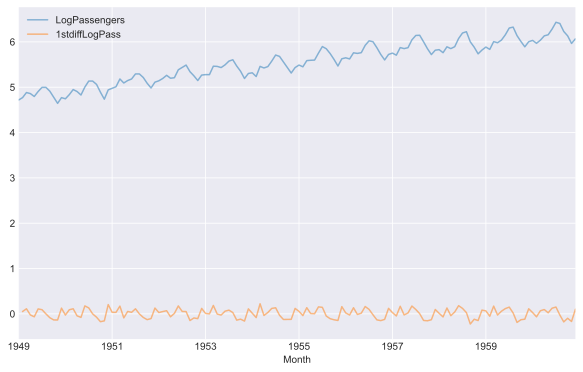

In [16]:
df['1stdiffLogPass'] = df['LogPassengers'].diff()

cols = df.columns.to_list()

fig, axes = plt.subplots(figsize = (10,6))

df[cols[2:]].plot(ax = axes, alpha = 0.5)

axes.grid()

The plot above confirms this for which we took the 1st differencing of the log transformed passenger data. 

In [17]:
# import arima class 
from statsmodels.tsa.arima.model import ARIMA

In [19]:
df.index.freq = 'MS'

In [20]:
# train test split and slicing 

N_test = 12

train, test = df[:-N_test], df[-N_test:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [22]:
# train the model with arima 1,0,0

arima = ARIMA(train['Passengers'], order = (1,0,0))

arima_result = arima.fit()

arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -642.188
Date:                Tue, 09 Apr 2024   AIC                           1290.376
Time:                        12:46:16   BIC                           1299.024
Sample:                    01-01-1949   HQIC                          1293.890
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        262.4900     59.459      4.415      0.000     145.953     379.027
ar.L1          0.9618      0.020     47.210      0.000       0.922       1.002
sigma2       965.3628    111.663      8.645      0.000     746.507    1184.218
===================================================================================
Ljung-Box (L1) (Q):                  11.49   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               7.93   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

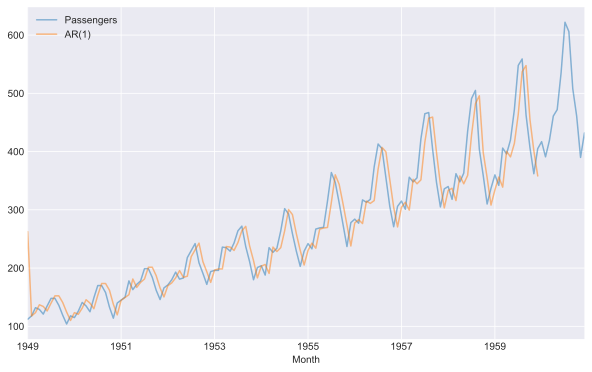

In [23]:
# get training predictions and plot 

df.loc[train_idx, 'AR(1)'] = arima_result.predict(start = train.index[0], end = train.index[-1])

fig, axes = plt.subplots(figsize = (10,6))

df[['Passengers','AR(1)']].plot(ax = axes, alpha = 0.5)

axes.grid()

Delayed structure is visible as an AR(1) model would behave: next value is just the weighted previous value, where as you can see the weight is pretty close to unity looking at the .summary() method. 

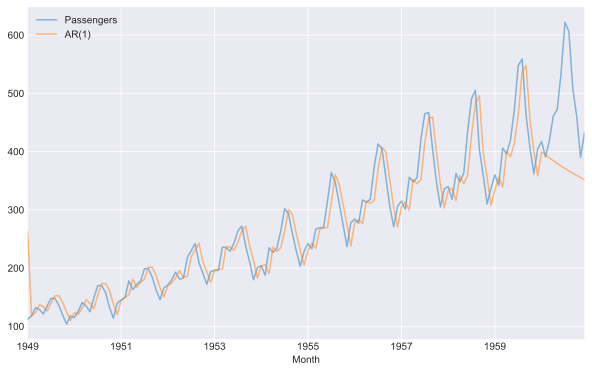

In [24]:
# get the predictions for test set and plot again 

pred_res = arima_result.get_forecast(N_test)

forecast = pred_res.predicted_mean

df.loc[test_idx, 'AR(1)'] = forecast

fig, axes = plt.subplots(figsize = (10,6))

df[['Passengers','AR(1)']].plot(ax = axes, alpha = 0.5)

axes.grid()

Model cant even capture the trend well. In fact, even a naive forecast would perform better than this model! 

In [25]:
# explore prediction result type 
type(pred_res)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [28]:
forecast

1960-01-01    399.554855
1960-02-01    394.317763
1960-03-01    389.280774
1960-04-01    384.436243
1960-05-01    379.776816
1960-06-01    375.295420
1960-07-01    370.985253
1960-08-01    366.839773
1960-09-01    362.852687
1960-10-01    359.017944
1960-11-01    355.329721
1960-12-01    351.782421
Freq: MS, Name: predicted_mean, dtype: float64

In [26]:
# confidence interval 

pred_res.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826172,478.809354
1960-03-01,287.732169,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373403,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [27]:
arima_result.fittedvalues

Month
1949-01-01    262.490027
1949-02-01    117.750054
1949-03-01    123.520801
1949-04-01    136.985876
1949-05-01    134.100503
                 ...    
1959-08-01    537.090987
1959-09-01    547.670689
1959-10-01    455.338740
1959-11-01    401.478437
1959-12-01    358.197836
Freq: MS, Length: 132, dtype: float64

In [29]:
def plot_fit_and_forecast(result):

    fig, axes = plt.subplots(figsize = (10,6))

    df['Passengers'].plot(ax = axes, label = 'Passenger Data')

    # plot the training predictions 

    train_pred = arima_result.fittedvalues

    train_pred.plot(ax = axes, color = 'green', alpha = 0.5, label = 'Fitted')

    # Test forecasts and confidence intervals 

    pred_result = result.get_forecast(N_test)

    conf_int = pred_result.conf_int()

    lc_int, uc_int = conf_int['lower Passengers'], conf_int['upper Passengers']

    forecast = pred_result.predicted_mean

    forecast.plot(ax = axes, color = 'red', alpha = 0.5, label = 'Forecast')

    axes.fill_between(test.index, lc_int, uc_int, color = 'red', alpha = 0.1)

    axes.legend()

    axes.grid()
    

    

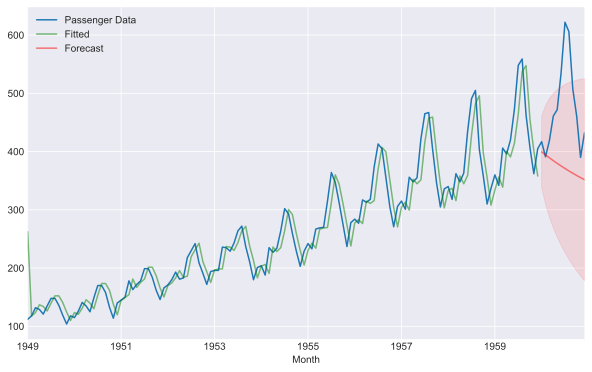

In [30]:
plot_fit_and_forecast(arima_result)

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


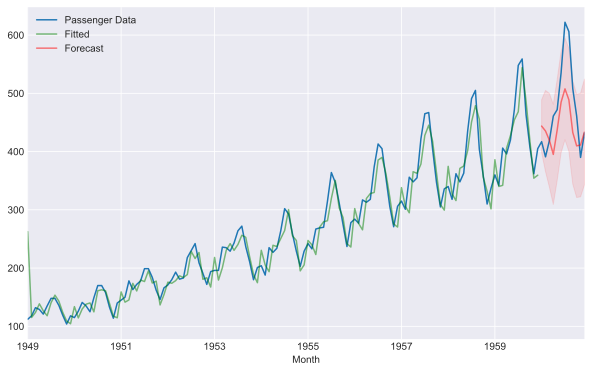

In [31]:
# trying different models 

arima = ARIMA(train['Passengers'], order = (10,0,0)) # AR(10)
arima_result = arima.fit()

plot_fit_and_forecast(arima_result)



/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


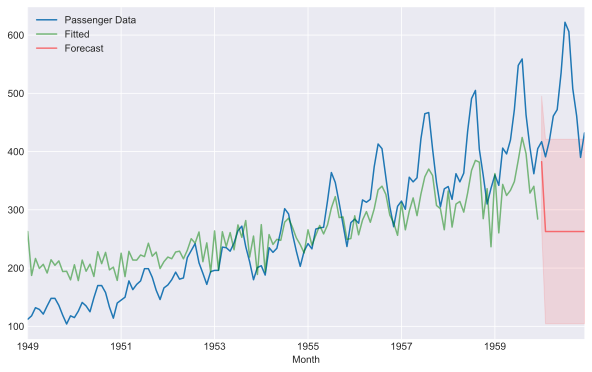

In [32]:
# MA(1) model 

arima = ARIMA(train['Passengers'], order = (0,0,1)) # AR(10)
arima_result = arima.fit()

plot_fit_and_forecast(arima_result)

In [33]:
train.head()

,Passengers,1stdiff,LogPassengers,1stdiffLogPass
Month,,,,
1949-01-01,112,NaN,4.718499,NaN
1949-02-01,118,6.0,4.770685,0.052186
1949-03-01,132,14.0,4.882802,0.112117
1949-04-01,129,-3.0,4.859812,-0.022990
1949-05-01,121,-8.0,4.795791,-0.064022


In [36]:
# Next build a model with built-in differencing 

arima = ARIMA(train['Passengers'], order = (8,1,1))
arima_res_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col = 'Passengers'):
    
    fig, axes = plt.subplots(figsize = (11,6))

    df[col].plot(ax = axes, label = 'Passenger Data')

    # Plot fitted training data 

    train_pred = result.predict(start = train.index[d], end = train.index[-1]) # we specify the differencing as the model build with a specified differencing 

    train_pred.plot(ax = axes, color = 'green', alpha = 0.5, label = 'Fitted')

    # forecast the test set 

    pred_res = result.get_forecast(N_test)

    conf_int = pred_res.conf_int()

    lc_int, uc_int = conf_int[f"lower {col}"], conf_int[f"upper {col}"]

    forecast = pred_res.predicted_mean

    forecast.plot(ax = axes, color = 'red', alpha = 0.5, label = 'Forecast')

    axes.fill_between(test.index,lc_int, uc_int, color = 'red', alpha = 0.1)

    axes.legend()
    axes.grid()


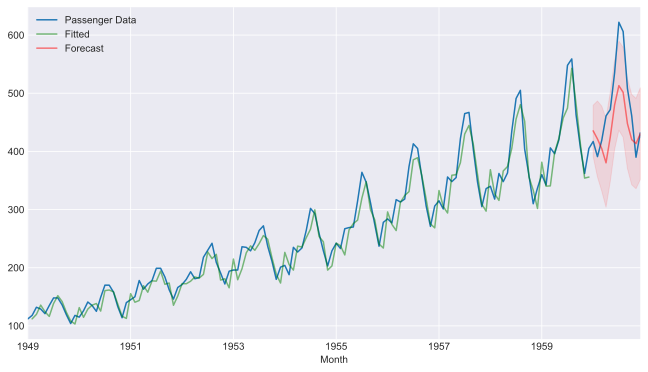

In [37]:
plot_fit_and_forecast_int(arima_res_811, 1)

Recall that taking the 1st differencing after log transform of passanger count was able to make the time series quite stationary which is required for ARIMA models to perform well. So next we can use the LogPassenger data with first differencing to see if the forecasts get improved. 

In [38]:
train.head()

,Passengers,1stdiff,LogPassengers,1stdiffLogPass
Month,,,,
1949-01-01,112,NaN,4.718499,NaN
1949-02-01,118,6.0,4.770685,0.052186
1949-03-01,132,14.0,4.882802,0.112117
1949-04-01,129,-3.0,4.859812,-0.022990
1949-05-01,121,-8.0,4.795791,-0.064022


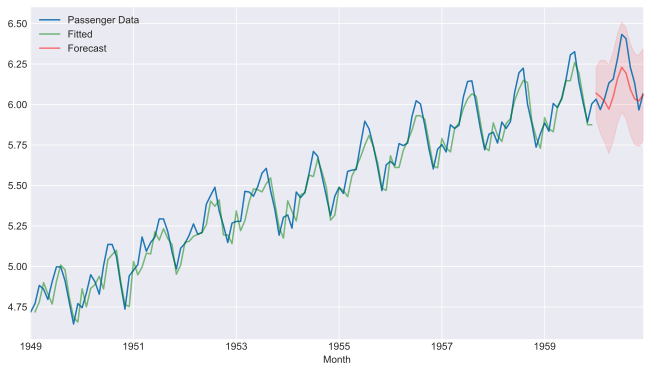

In [39]:
arima = ARIMA(train['LogPassengers'], order = (8,1,1))
arima_res_l811 = arima.fit()

plot_fit_and_forecast_int(arima_res_l811, 1, col = 'LogPassengers')

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


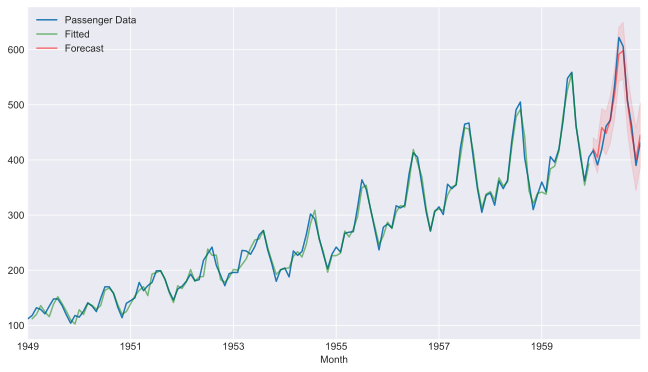

In [40]:
# Next add more autoregressive terms 

arima = ARIMA(train['Passengers'], order = (12,1,0))
arima_res_1210 = arima.fit()

plot_fit_and_forecast_int(arima_res_1210, 1)

Seems to perform much better than everything else we tried so far. 

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


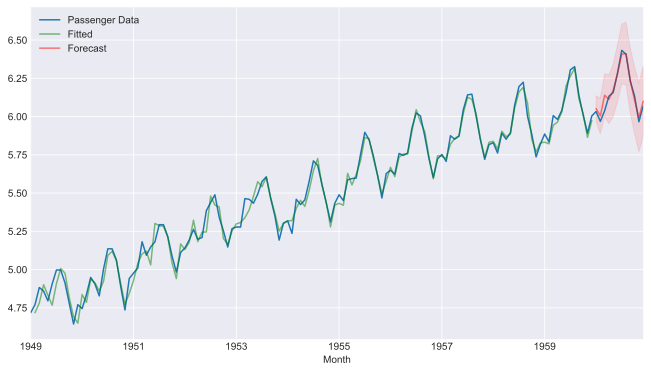

In [41]:
# Next use the log transformed data with the same model where more autoregressive terms are added

arima = ARIMA(train['LogPassengers'], order = (12,1,0))
arima_res_l1210 = arima.fit()

plot_fit_and_forecast_int(arima_res_l1210, 1, col = 'LogPassengers')

It is hard to tell which one performs better by just looking at the plots as one has a log scale and the other dont. We can use the RMSE metric to decide!

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(result, is_logged):

    forecast = result.forecast(N_test)

    if is_logged:

        forecast = np.exp(forecast)

    rmse = mean_squared_error(test['Passengers'],forecast, squared=False)

    return rmse



In [45]:
print(f"RMSE for ARIMA(8,1,1): {rmse(arima_res_811, False):.2f}")
print(f"RMSE for logged ARIMA(8,1,1): {rmse(arima_res_l811, True):.2f}")
print(f"RMSE for ARIMA(12,1,0): {rmse(arima_res_1210, False):.2f}")
print(f"RMSE for logged ARIMA(12,1,0): {rmse(arima_res_l1210, True):.2f}")

RMSE for ARIMA(8,1,1): 59.06
RMSE for logged ARIMA(8,1,1): 61.61
RMSE for ARIMA(12,1,0): 17.48
RMSE for logged ARIMA(12,1,0): 16.10
